In [39]:
import cv2 
import numpy as np
import os
import platform
if platform.system() =="Windows" or platform.system() =="linux": # MacOS: posix
    import matplotlib.pylab as plt
import math 
import dis
import numba 
import time

def OpeningRectangle(image, width, height):
    mask = cv2.getStructuringElement(cv2.MORPH_RECT, ksize = (width, height))
    erosion = cv2.erode(image, mask, iterations = 1, borderType = cv2.BORDER_DEFAULT, borderValue = 0)
    opening = cv2.dilate(erosion, mask, iterations = 1, borderType = cv2.BORDER_DEFAULT, borderValue = 0)
    return opening

def SelectShapeStd(Region, mode = "area"): # SELECT SHAPE STD
        numLabels, labels, stats, _ = cv2.connectedComponentsWithStats(Region, 8, cv2.CV_32S)
        h, w = Region.shape

        SelectedRegion = np.zeros((h, w), np.uint8)

        if numLabels <= 1:
            return SelectedRegion, 0
        if mode == "area":
            features = list(stats[1:,4])
            
        elif mode == "width":
            features = list(stats[1:,2])   
            
        elif mode == "height":
            features = list(stats[1:,3])   
            
        max_value  = max(features)
        index = features.index(max_value) + 1
        print(f'index:{index}')
        ObjectSelected = np.array(labels, dtype=np.uint8)

        ObjectSelected[index == labels] = 255
        ObjectSelected[index != labels] = 0

        return ObjectSelected

def FillUp(region):
    region =region.astype(np.uint8)
    # add padding
    im_floodfill = cv2.copyMakeBorder(region, 1, 1, 1, 1, cv2.BORDER_CONSTANT, 0)

    # Create mask (ROI)
    h, w = im_floodfill.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    cv2.floodFill(im_floodfill, mask, (0,0), 255, flags = 4)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_floodfill_inv = im_floodfill_inv[1:(1 + region.shape[0]), 1:(1 + region.shape[1])]

    RegionFillUp = region | im_floodfill_inv
    return RegionFillUp

def OpeningRectangle(image, width, height):
    mask = cv2.getStructuringElement(cv2.MORPH_RECT, ksize = (width, height))
    erosion = cv2.erode(image, mask, iterations = 1, borderType = cv2.BORDER_DEFAULT, borderValue = 0)
    opening = cv2.dilate(erosion, mask, iterations = 1, borderType = cv2.BORDER_DEFAULT, borderValue = 0)
    return opening

def find_formula_line(point1, point2):
    # song song voi truc Ox thi y = nhau
    x1,y1 = point1
    x2,y2 = point2

    if y1 == y2:
        A = 0.0
        B = 1.0
        C = - y1

    # song song voi truc Oy thi x = nhau
    elif x1 == x2:
        A = 1.0
        B = 0.0
        C = - x1
    
    # cat ox, oy   
    else:
        A = (y1 - y2)/(x1-x2)
        B = -1
        C = y2 - A * x2

    return A, B, C

def line_intersection(line1,line2):
        # Tính giá trị của x và y tương ứng với điểm giao điểm của hai đường thẳng
        # Giải hệ phương trình A1x + B1y + C1 = 0 và A2x + B2y + C2 = 0
        # Tính định thức D
        # Unboxing
        
        A1, B1, C1 = line1
        A2, B2, C2 = line2

        # Tính định thức hệ số x:
        det_x = B1 * C2 - B2 * C1

        # Tính định thức hệ số y:
        det_y = A2 * C1 - A1 * C2

        # Tính định thức chung:
        det = A1 * B2 - A2 * B1

        # Tính tọa độ giao điểm (x, y)
        x = det_x / det
        y = det_y / det

        return x, y

def ErodeRectangle(region , width, height):
    mask = cv2.getStructuringElement(cv2.MORPH_RECT, ksize = (2*width + 1, 2*height + 1))
    erosion = cv2.erode(region, mask , iterations = 1, borderType = cv2.BORDER_DEFAULT, borderValue = 0)
    return erosion 

def SelectShape(threshold,min_value, max_value, feature = "width"): 
    
        number_object,labels , stats, _ = cv2.connectedComponentsWithStats(threshold, 4, cv2.CV_32S)
        
        list_width = list(stats[1: ,2])
        list_height = list(stats[1: ,3])
        list_area = list(stats[1: ,4])
        
        #
        result = np.zeros((threshold.shape[0], threshold.shape[1]),dtype =np.uint8)
        # 
        list_output_width = []
        list_output_height = []
        list_output_area =[]
        #
        list_region  = []
        # ----------------------------------------------------- WIDTH
        if feature == "width":
            for idx in range(1,number_object):
                width  = list_width[idx -1]
                height = list_height[idx -1]
                area   = list_area[idx -1]
                
                if width > min_value  and width < max_value:
                    select_object = np.zeros( (threshold.shape[0], threshold.shape[1]),dtype =np.uint8)
                    
                    select_object[labels == idx] = 255
                    select_object[labels != idx] = 0
                    
                    list_region.append(select_object)
                    result = cv2.bitwise_or(result,select_object)
                    list_output_width.append(width)
                    
                    list_output_height.append(height)
                    list_output_area.append(area)
                    
            return result,list_region,(list_output_width,list_output_height,list_output_area)
        
        # ----------------------------------------------------- HEIGHT 
        elif feature == "height":
            for idx in range(1,number_object):
                width  = list_width[idx -1]
                height = list_height[idx -1]
                area   = list_area[idx -1]
                
                if height > min_value  and height < max_value:
                    select_object = np.zeros( (threshold.shape[0], threshold.shape[1]),dtype =np.uint8)
                    
                    select_object[labels == idx] = 255
                    select_object[labels != idx] = 0
                    
                    list_region.append(select_object)
                    
                    result = cv2.bitwise_or(result,select_object)
                    list_output_width.append(width)
                    
                    list_output_height.append(height)
                    list_output_area.append(area)
                    
            return result,list_region,(list_output_width,list_output_height , list_output_area     )         
        
        # ----------------------------------------------------- AREA
        elif feature == "area":
            for idx in range(1,number_object):
                width  = list_width[idx -1]
                height = list_height[idx -1]
                area   = list_area[idx -1]
                
                if area > min_value  and area < max_value:
                    
                    select_object = np.zeros( (threshold.shape[0], threshold.shape[1]),dtype =np.uint8)
                    
                    select_object[labels == idx] = 255
                    select_object[labels != idx] = 0
                    
                    list_region.append(select_object)
                    
                    result = cv2.bitwise_or(result,select_object)
                    list_output_width.append(width)
                    
                    list_output_height.append(height)
                    list_output_area.append(area)
                    
            return result,list_region,(list_output_width,list_output_height , list_output_area)
        
        # ----------------------------------------------------- Circularity 
        # ----------------------------------------------------- Squaredness 

def OpeningCircle(image, radius):
    mask = cv2.getStructuringElement(cv2.MORPH_CROSS, ksize = (2*radius + 1, 2*radius + 1))
    erosion = cv2.erode(image, mask , iterations = 1, borderType = cv2.BORDER_DEFAULT, borderValue = 0)
    opening = cv2.dilate(erosion, mask , iterations = 1, borderType = cv2.BORDER_DEFAULT, borderValue = 0)
    return opening

def minimum_distance_point_to_line(point, line):
    if len(point)!=2 or len(line)!=3:
            return None
    
    x1,y1 = point
    A, B, C  = line
    if A==0 and B==0:
        return None
    dis_min = abs(A*x1 + B*y1 +C) /  math.sqrt(A**2 + B**2)
    return dis_min

def ErodeCircle(region , radius):
    mask = cv2.getStructuringElement(cv2.MORPH_CROSS, ksize = (2*radius + 1, 2*radius +1))
    erosion = cv2.erode(region, mask , iterations = 1, borderType = cv2.BORDER_DEFAULT, borderValue = 0)
    return erosion 

def showC(img):
    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(rgb,cmap="gray")
    
def show(img):
    plt.imshow(img,cmap="gray")
    
def timer(func):
    def wrapper( *args, **kwargs):
        t0 = time.time()
        result = func(*args, **kwargs)
        t1 =time.time()
        print(f'Function {func.__name__} took: {round((t1-t0)*1000, 6)} (ms)')
        return result
    return wrapper 

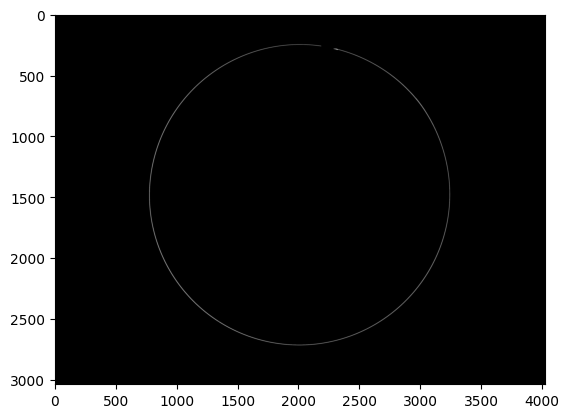

In [40]:
img = cv2.imread("images/missingEdge.bmp")
img_copy = img.copy()
gray = cv2.imread("images/missingEdge.bmp",0 )
show(gray)

## Teaching (Create ROI when teaching)

### Create Mask

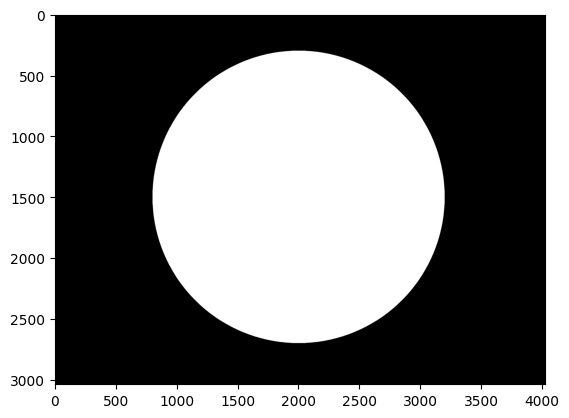

In [41]:
black_mask = np.zeros((gray.shape[0], gray.shape[1]),dtype = np.uint8 )

cv2.circle(black_mask, (2000,1500),200, (255,255,255),2000)
show(black_mask)

### Threshold Range -> Find Len Location

Function ThresholdRange took: 7.811785 (ms)
index:1


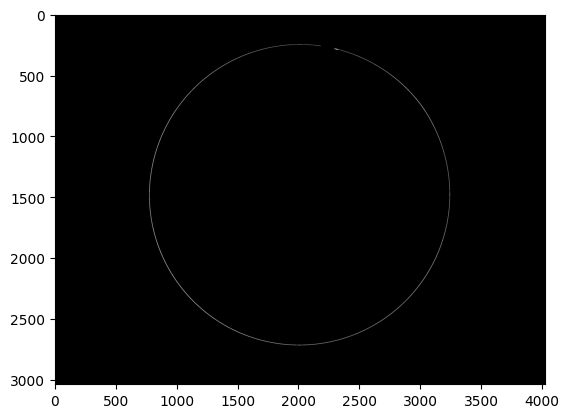

In [42]:
@timer
def ThresholdRange(gray, t1, t2):
        """
            t1 < t2
        """
        _, threshold1 = cv2.threshold(gray, t1, 255, cv2.THRESH_BINARY)
        _, threshold2= cv2.threshold(gray, t2, 255, cv2.THRESH_BINARY)
        
        threshold = cv2.bitwise_xor(threshold2,threshold1, mask= None)
        return threshold
    
threshhold = ThresholdRange(gray, 110 ,255)

len_location = SelectShapeStd(threshhold)
show(len_location)

### Region to Contour and ConvexHull

In [43]:
contours, _ =cv2.findContours(len_location,  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
len(contours[0])
moment = cv2.moments(contours[0])
center_x = int(moment["m10"] / moment["m00"])
center_y = int(moment["m01"] / moment["m00"])
print(center_x, center_y)

1896 1580


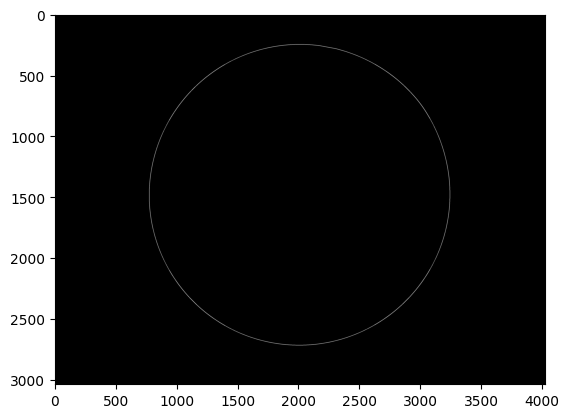

In [44]:
def ConvexHull(contour):
    len(contour)
    if len(contour) ==0 :
        return []
    # ConvextHull 
    hull_list = []
    for cnt in contour:
        hull_list.append (cv2.convexHull(cnt[1:]))
         
    return  hull_list

def DrawContourMask(size, cnt, thickness = 2):
    mask = np.zeros((size[0], size[1]), dtype = np.uint8)
    cv2.drawContours(mask,cnt, -1,  (255),thickness)
    return mask    

hull  = ConvexHull(contours)
mask  = DrawContourMask((gray.shape[:2]),hull, thickness = 2)
show(mask)

### Line and Contours Intersection Foundation

* Line (A,B,C)
* Contours: Array of Point
* Result:$$-> Return \space Point \space in \space Intersection \space Collection \space point$$ 

In [45]:
@timer
@numba.jit(parallel = True)
def intersec_line_contour(line, contours):
    point_intersec = []
    
    return point_intersec

C:\Users\manmu\AppData\Local\Temp\ipykernel_10788\1388062036.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(parallel = True)


### Find Intersection Line and Contours 1

In [46]:
def rotate_point(P, O, alpha):
    # Degree -> Radian
    alpha_rad = math.radians(alpha)

    # Cordinate P 
    x = P[0] - O[0]
    y = P[1] - O[1]
    x_prime = x * math.cos(alpha_rad) - y * math.sin(alpha_rad)
    y_prime = x * math.sin(alpha_rad) + y * math.cos(alpha_rad)

    # Cordinate in O
    x_prime += O[0]
    y_prime += O[1]

    return int(x_prime), int(y_prime)

@timer
def FindMissingEdge(threshold, center):
    R = 20
    P =(int(center[0]),R)
    step = 0.5 # Define Dregree
    # 12H -> 
    num_step = int(360 / step)
    result = np.zeros(threshold.shape[:2], dtype = np.uint8)
    for i in range(1,num_step+1): 
        alpha = step * i
        x_prime , y_prime = rotate_point(P,center, alpha )
        P = (x_prime , y_prime)
        
        mask = np.zeros(threshold.shape[:2], dtype = np.uint8)
        cv2.line(mask, (int(center[0]), int(center[1])), (x_prime,y_prime), (255,255,255),5)
        
        diff = cv2.bitwise_and(mask,threshold, mask = None)
        if (np.any(diff == 255)) == False:
            result = cv2.bitwise_or(result,mask)
            
    return result

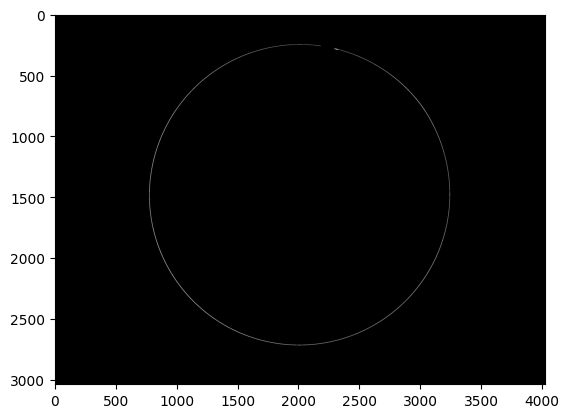

In [47]:
show(len_location)

In [48]:
result = FindMissingEdge(len_location,(center_x, center_y))

Function FindMissingEdge took: 9587.72397 (ms)


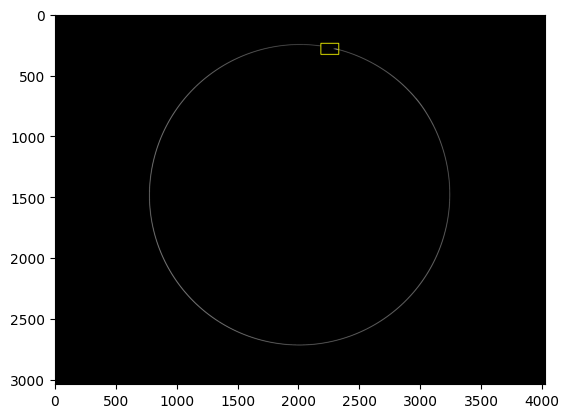

In [49]:
show(result)
diff = cv2.bitwise_and(mask, result, mask = None)
x,y,w,h =  cv2.boundingRect(diff)
offset = 25
img_copy = img.copy()
cv2.rectangle(img_copy,(x-offset,y - offset), (x+w+ 2*offset, y+h +2*offset), (255,255,0), 6)
show(img_copy)

### Find intersection Line and Contours

In [50]:
# Tạo hai mảng hình ảnh đơn giản
array1 = np.array([[0, 0, 0],
                   [0, 255, 0],
                   [0, 0, 0]])

array2 = np.array([[0, 255, 0],
                   [0, 3, 0],
                   [0, 255, 0]])

# Tìm vị trí và giá trị pixel chung
common_positions = np.where((array1 == 255) & (array2 == 255))
print(len(common_positions[0]))

0


In [51]:
def rotate_point(P, O, alpha):
    """
        Input: P point 
        Ouput: P': kết quả của phép xoay tâm 0, góc alpha -> (int(x_prime), int(y_prime))
    
    """
    # Degree -> Radian
    alpha_rad = math.radians(alpha)

    # Cordinate P 
    x = P[0] - O[0]
    y = P[1] - O[1]
    x_prime = x * math.cos(alpha_rad) - y * math.sin(alpha_rad)
    y_prime = x * math.sin(alpha_rad) + y * math.cos(alpha_rad)

    # Cordinate in O
    x_prime += O[0]
    y_prime += O[1]

    return (int(x_prime), int(y_prime))

@timer
def FindMissingEdge(threshold, center):
    R = 20
    P =(int(center[0]),R)
    step = 0.5 # Define Dregree
    # 12H -> 
    num_step = int(360 / step)
    result = np.zeros(threshold.shape[:2], dtype = np.uint8)
    for i in range(1,num_step+1): 
        alpha = step * i
        x_prime , y_prime = rotate_point(P,center, alpha )
        P_new = (x_prime , y_prime)
        mask = np.zeros(threshold.shape[:2], dtype = np.uint8)
        cv2.line(mask, (int(center[0]), int(center[1])), P_new, (255,255,255),5)

        diff = cv2.bitwise_and(mask,threshold, mask = None)
        if (np.any(diff == 255)) == False:
            #result = cv2.bitwise_or(result,mask)
            result = result | mask
            
    return result

In [52]:
result = FindMissingEdge(len_location,(center_x, center_y))

Function FindMissingEdge took: 9728.287935 (ms)


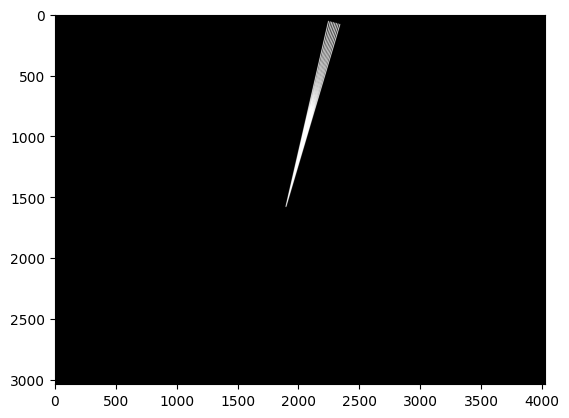

In [53]:
show(result)

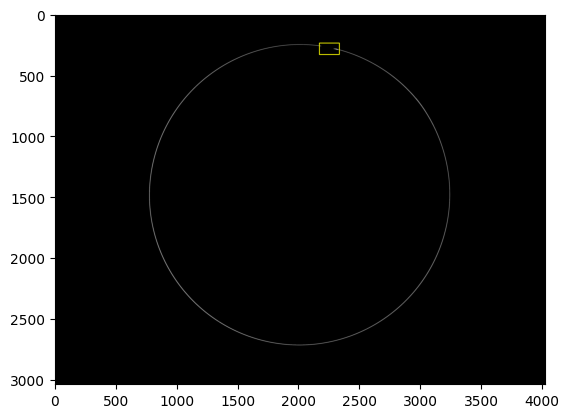

In [54]:
show(result)
diff = cv2.bitwise_and(mask, result, mask = None)
x,y,w,h = cv2.boundingRect(diff)
offset = 25
img_copy =img.copy()
cv2.rectangle(img_copy,(x-offset,y - offset), (x+w+ 2*offset, y+h +2*offset), (255,255,0), 6)
show(img_copy)